# VGG-16 Model on CIFAR-10 Dataset
*Author: Gian Carlo Baldonado*

## Objective
The goal of this notebook is to apply the VG-16 pretrained model on the CIFAR-10 dataset. 

## Resources
* **About VGG-16**
The VGG model is based on the Very Deep Convolutional Networks for Large-Scale Image Recognition paper. VGG16 is a convolution neural net architecture used for image recognition. It uses 16 layers with weights. https://arxiv.org/abs/1409.1556

* **About CIFAR-10**
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. http://www.cs.toronto.edu/~kriz/cifar.html

## 1.) Import packages and notebook settings

In [69]:
# requisite imports
import torch
import tqdm 
import time
import os

import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random

import torch.optim as optim

import numpy as np

**Device setting**: Devices with MPS available will use MPS, cuda will use cuda, and if both are not available, `device` is set to CPU.

In [50]:
device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda:0' if torch.cuda.is_available() else 'cpu'))
print(device)

mps


**Seed Setting**:
Different sources of randomness contribute to the result of a neural network model. Nevertheless, a good neural network model should not depend on the eed but the data, architecture, and hyperparameters used. We introduce a seed value for the sake of reproducibility of our results. We set the `seed_value` to `42` for the following sources of randomness:
1. within the environment
2. within Python
3. within some packages like numpy and torch
4. and anywhere else where randomness is introduced like within architectures (some dropout layers introduce randomness) 


In [6]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` and `torch` pseudo-random generator at a fixed value
np.random.seed(seed_value)
torch.manual_seed(seed_value)

**Variable setting**

In [58]:
BATCH_SIZE = 64
NUM_EPOCHS = 5
LR = 2E-5

# 2.) Load and Transform CIFAR-10 dataset

The CIFAR-10 dataset is popular enough that `torchvision.datasets` has CIFAR-10 as one of its built-in datasets. https://pytorch.org/vision/stable/datasets.html#datasets

In [ ]:
# Load the CIFAR train dataset
train = torchvision.datasets.CIFAR10("data/", train=True, download=True)
test = torchvision.datasets.CIFAR10("data/", train=False, download=True) 

**Transform**: Transforming a dataset when loading it is an important and common practice in computer vision. It is used for the following:
* *Data augmentation*: Increase the size and diversity of dataset, which can improve model performance. For ex., flip, rotate or crop images to create new images.
* *Normalization*: Normalize the distribution of hte pixel values, making the data easier for the model to learn.
* *Preprocessing*: Prepare data for a specific model, like perhaps you need to resize the images or convert them to another format.

Note: You can skip `transform` but it is not recommended. It may lead to overfitting, poor performance, or incompatibility of the data with the model you're using.

Resource on transformation: https://pytorch.org/vision/main/transforms.html

To start, I chose *normalization* for transformation.

In [17]:
# print(train.data) #train.data is of type numpy array 
# normalize train.data by dividing the array by 255. This will normalize all of the pixel values in the array between 0 and 1. 
# 255 is the max value for a pixel in a typical image.
normalized_train = train.data / 255
mean = normalized_train.mean(axis = (0,1,2))
std = normalized_train.std(axis = (0,1,2))
print(f"train mean: {mean}, train std: {std}")

train mean: [0.49139968 0.48215841 0.44653091], train std: [0.24703223 0.24348513 0.26158784]


We will feed these `mean` and `std` to the `transforms.v2.Compose()`

In [54]:
transform = transforms.v2.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

# reload our train and test sets with transformation
train = torchvision.datasets.CIFAR10("data/", train=True, download=False, transform=transform) 
test = torchvision.datasets.CIFAR10("data/", train=True, download=False, transform=transform) 

# size of the validation set
val_size = 10000

# size of the train set
train_size = len(train) - val_size

# split the train into a train and a validation set, in accordance to the determined train and val sizes
train, val = random_split(train, [train_size, val_size])

# load the train, test, and val to our dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Visualizing images**

In [55]:
std

array([0.24703223, 0.24348513, 0.26158784])

In [56]:
def imshow(img):
    img_np = img.numpy()
    img_np = img_np / 2 + 0.5 # unnormalize image
    plt.axis('off')
    plt.imshow(np.transpose(img_np, (1,2,0)))
    plt.show
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship bird frog horse horse frog deer dog horse plane truck horse plane deer bird car truck frog frog cat truck ship horse car plane truck cat cat deer bird frog dog ship horse cat dog truck car ship deer ship horse deer ship truck truck frog cat car dog horse cat deer ship horse frog deer bird car ship car deer dog bird


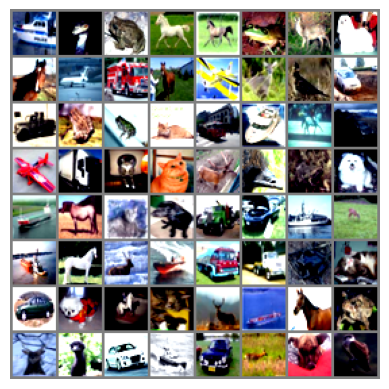

In [60]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(BATCH_SIZE)))

## 3. Define a GGV-16 Neural Network

**How models work in PyTorch**
Every custom model is inherited from the `nn.Module` class. This class provides basic functionality that helps the model to train. There are 2 main things we need to define:
* `__init__` 
* `forward` 

**Types of layers and definitions**

* `nn.Conv2d`: convolutional layers that accepts no. of input and output channels as args, along with kernel size for the filter. It accepts strides and paddings as well, if you wish to implement this.
* `nn.Batchnormd2`: batch normalization layers for the output of the convolutional layers.
* `nn.ReLU`: an activation layer applied to the outputs in the network.
* `nn.MaxPool2d`: max pooling layer to the output with the given kernel size
* `nn.DropOut`: dropout regularization layer with a given probability
* `nn.Linear`: essentially a fully connected layer
* `nn.Sequential`: not really a layer, but combines different operations part of the same step

In [63]:
class VGG16(nn.Module):
    # paper implementation of GGV-16
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Instantiate a model and transfer it to the device.

In [68]:
model = VGG16()
model.to(device)

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

**Define a loss function and optimizer**

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)